# TNS Ledger Maker

Access CSV downloads from TNS and produce a DESI ToO ledger.

In [1]:
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack
from astropy import units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)

## Access CTIO-4m-DECAM Data

Grab CSV data downloaded from TNS sent from DESIRT.

The search is specifically from the GAMA15 fields observed by DECam from late March to mid-April 2021.

In [3]:
# data = ascii.read('desirt_ztf_tns_20210418.csv')
data = Table.read('tns_search_20220420_3mo.csv')
# data_decam = ascii.read('desirt_tns_20210415.csv')
# data_ztf = ascii.read('ztf_tns_20210415.csv')
# print(data_decam.keys())
# print(data_ztf.keys())
# vstack([data_ztf, data_decam], metadata_conflicts='silent')
# data_decam #= data_decam + data_ztf

In [4]:
# Cut out masked filters.
select = ~data['Discovery Filter'].mask & ~data['Reporting Group/s'].mask
data = data[select]
data['Discovery Date (MJD)'] = Time(data['Discovery Date (UT)'], scale='utc').mjd
data.sort('Discovery Date (MJD)', reverse=True)

data

col0,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s,Discovery Date (MJD)
int64,int64,str11,str12,str12,str17,float64,str30,float64,str49,str43,str39,str49,str29,str114,str50,int64,int64,int64,float64,str12,str23,str18,int64,int64,float64
18,107084,AT 2022hxj,11:55:48.946,-01:45:36.46,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dml,PS2 - GPC2,--,1,1,--,20.96,w-P1,2022-04-20 07:17:59.424,PS2_Bot1,--,--,59689.30416
20,107082,AT 2022hxh,11:48:34.123,+00:19:14.27,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dmj,PS2 - GPC2,--,1,1,--,20.62,w-P1,2022-04-20 07:17:04.128,PS2_Bot1,--,--,59689.30352
8,107094,AT 2022hxt,11:44:14.681,-02:59:14.81,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dmx,PS2 - GPC2,--,1,1,--,20.95,w-P1,2022-04-20 07:16:09.696,PS2_Bot1,--,--,59689.30289
19,107083,AT 2022hxi,11:53:01.432,-03:51:00.29,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dmk,PS2 - GPC2,--,1,1,--,20.89,w-P1,2022-04-20 07:15:15.264,PS2_Bot1,--,--,59689.30226
13,107089,AT 2022hxo,11:45:07.119,-08:44:19.15,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dmr,PS2 - GPC2,--,1,1,--,20.94,w-P1,2022-04-20 07:13:22.080,PS2_Bot1,--,--,59689.30095
16,107086,AT 2022hxl,11:33:17.454,-00:53:55.23,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dmo,PS2 - GPC2,--,1,1,--,19.83,w-P1,2022-04-20 07:09:41.760,PS2_Bot1,--,--,59689.2984
17,107085,AT 2022hxk,11:06:58.146,-02:49:04.58,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dmm,PS2 - GPC2,--,1,1,--,21.01,w-P1,2022-04-20 07:07:52.032,PS2_Bot1,--,--,59689.29713
12,107090,AT 2022hxp,11:12:50.631,-02:26:04.92,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dms,PS2 - GPC2,--,1,1,--,19.51,w-P1,2022-04-20 07:07:52.032,PS2_Bot1,--,--,59689.29713
14,107088,AT 2022hxn,11:16:03.451,-01:36:59.73,--,--,--,--,Pan-STARRS,Pan-STARRS,--,Pan-STARRS,PS22dmq,PS2 - GPC2,--,1,1,--,20.78,w-P1,2022-04-20 07:07:52.032,PS2_Bot1,--,--,59689.29713


### Diagnostic Plots

In [5]:
ra, dec = data['RA'], data['DEC']
mag = data['Discovery Mag/Flux']
mag_cut = None

filters = data['Discovery Filter']
fname, fcount = (np.unique(filters, return_counts=True))
for _a, _b in zip(fname, fcount):
    print('{:10s} {}'.format(_a, _b))
coords = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.degree), frame='icrs')

B-Johnson  10
Clear-     131
G-Gaia     772
L-         2
R-Cousins  7
R-PTF      2
V-crts-CRTS 7
cyan-ATLAS 367
g-HSC      1
g-P1       52
g-Sloan    58
g-ZTF      1127
i-P1       79
i-Sloan    70
orange-ATLAS 674
r-P1       44
r-Sloan    13
r-ZTF      1073
w-P1       1683
y-P1       1
z-HSC      1
z-P1       24
z-Sloan    13


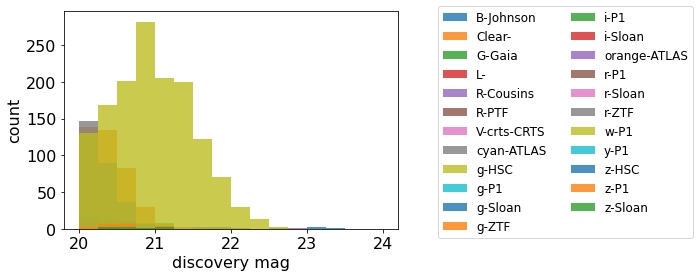

In [6]:
for filt in np.unique(filters):
#     if 'ZTF' in filt:
    plt.hist(mag[filters==filt], bins=np.linspace(20,24,17), alpha=0.8, label=filt)

if mag_cut is not None:
    plt.axvline(mag_cut, color='k', ls='--')
plt.legend(fontsize=12, ncol=2, bbox_to_anchor=(1.1, 1.05))
plt.xlabel('discovery mag')
plt.ylabel('count');

In [7]:
def plot_radec(coords, mag):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    coords : ndarray
        Array of SkyCoords.
    mag : ndarray
        Array of optical magnitudes.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})

    _ra = np.pi - coords.ra.to_value('rad')
    _dec = coords.dec.to_value('rad')

    sc = ax.scatter(_ra, _dec, c=mag, cmap='magma', alpha=0.5, s=5)
    cb = fig.colorbar(sc, fraction=0.046, pad=0.04)
    cb.set_label('discovery magnitude')

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    fig.tight_layout()

    return fig;

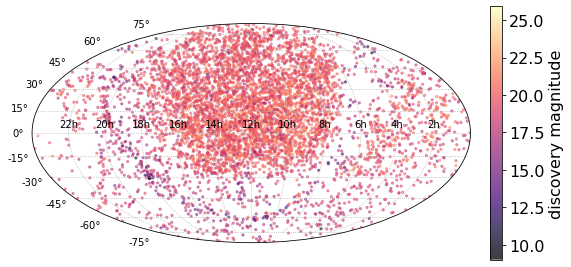

In [8]:
fig = plot_radec(coords, mag)

## Write ToO Ledger

In [9]:
def write_too_ledger(filename, too_table, checker, overwrite=False, verbose=False):
    """Write ToO ledger in the ECSV format specified by Adam Meyers.
    These can be passed to fiberassign for secondary targeting.
    
    Parameters
    ----------
    filename : str
        Output filename of the ledger (can be an absolute path).
    too_table : pandas.DataFrame
        Table of ToO data, using DECam format.
    checker : str
        Initials of individual(s) who have verified the ToO list.
    overwrite : bool
        If True, overwrite the output file.
    verbose : bool
        If True, 
    """
    mode = 'w' if overwrite else 'a'
    if verbose:
        mode = mode + '+'
    
    with open(filename, mode) as outf:
        if overwrite:
            outf.write("""# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID\n""")
            
        today = Time.now()
        datedict = {}
        reporting = []
        too_ids = []
            
        for j, row in enumerate(too_table):
            # Ledger format:
            # datatype:
            # - {name: RA, unit: deg, datatype: float64}
            # - {name: DEC, unit: deg, datatype: float64}
            # - {name: PMRA, unit: mas / yr, datatype: float32}
            # - {name: PMDEC, unit: mas / yr, datatype: float32}
            # - {name: REF_EPOCH, unit: yr, datatype: float32}
            # - {name: CHECKER, datatype: string}
            # - {name: TOO_TYPE, datatype: string}
            # - {name: OCLAYER, datatype: string}
            # - {name: MJD_BEGIN, unit: d, datatype: float64}
            # - {name: MJD_END, unit: d, datatype: float64}
            coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.hourangle, u.degree), frame='icrs')
            ra, dec = coord.ra.to_value('deg'), coord.dec.to_value('deg')
            mjd_disc = row['Discovery Date (MJD)']

            mag  = row['Discovery Mag/Flux']
            too_type = 'FIBER'
            too_prog = 'BRIGHT' # if mag < 21 else 'DARK'
            too_prio = 'LO'
            
            # Encode the ToO ID as: YY + DOY + NNNN.
            # E.g., ToO 15 of 17 Apr 2021 will get ID 211070015.
#             ttup = t_disc.to_datetime().timetuple()
#             yydoy = 1000*(ttup.tm_year-2000) + ttup.tm_yday
            
#             if yydoy in datedict:
#                 datedict[yydoy] += 1
#             else:
#                 datedict[yydoy] = 1

#             too_id = 10000*yydoy + datedict[yydoy]

            # Encode the ToO ID as: MJD + ID + NNN.
            reporter = row['Reporting Group/s'].split(',')[0]
            if reporter not in reporting:
                reporting.append(reporter)
            mjd_exp = 100*int(mjd_disc) + reporting.index(reporter)
            if mjd_exp in datedict:
                datedict[mjd_exp] += 1
            else:
                datedict[mjd_exp] = 1
            too_id = 100*mjd_exp + datedict[mjd_exp]
            
            # Awful hack to prevent duplicate IDs. WILL CAUSE DATA LOSS!
            if too_id in too_ids:
                continue
            too_ids.append(too_id)

            epoch = 2000.0

            outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                    ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog,
#                     mjd_disc,
#                     mjd_disc + 14,
                    today.mjd - 7,
                    today.mjd + 7,
                    too_id))
#             outf.write('{} {} {} {}\n'.format(reporter, reporting.index(reporter), mjd_exp, datedict[mjd_exp]))
    
        if verbose:
            outf.seek(0)
            for line in outf:
                print(line.strip())

In [10]:
write_too_ledger('ToO-input.ecsv', data, checker='SB/AP', overwrite=True, verbose=True)

# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID
178.953942  -1.760128 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596890001
177.142179   0.320631 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.7

232.611083  43.946789 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490105
193.691558  -4.368131 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490401
196.427575   7.160442 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490402
214.167792  44.202919 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490106
193.461271 -26.473597 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490004
199.295542  42.418861 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490107
183.646887 -27.954517 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490005
181.790062 -26.879258 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490006
231.464167  38.770550 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596490108
176.057300 -14.8854

249.534483  41.398897 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230808
249.869775  37.220661 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230240
213.731496  30.887467 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230327
217.741892  15.765464 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230809
205.479517  15.361108 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230328
208.608717  14.697689 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230810
203.668083   4.442242 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230241
208.794971   8.117411 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230329
219.180608  -9.411394 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596230330
200.201350   5.8349

140.553179 -10.082867 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040025
140.171604 -10.263158 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040026
140.182400  -9.009017 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040027
140.073867 -12.260269 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040028
139.637408 -12.630753 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040029
136.907771 -12.841481 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040030
133.365750 -15.465508 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040031
133.826967  36.086394 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040117
156.941779  -3.826767 0.000000 0.000000 2000.0 SB/AP FIBER LO BRIGHT 59682.76573346 59696.76573346 596040401
155.407067  -4.3130

In [11]:
# toos = None

# for _ra, _dec in zip((220.8908, 221.0202, 221.1424), (-0.758, -0.7057, -0.8466)):
#     yup = np.logical_and(np.abs(coords.ra.value - _ra) < 0.01, np.abs(coords.dec.value - _dec) < 0.01)
#     j = np.argwhere(yup)[0,0]
#     #     j = np.argwhere(np.abs(coords.ra.value - _ra) < 0.01 and np.abs(coords.dec.value - _dec) < 0.01)[0,0]

#     if toos is None:
#         toos = data[j]
#     else:
#         toos = vstack([toos, data[j]])

In [12]:
# toos.write('too_tile252_20210419.csv', format='ascii.csv', overwrite=True)

In [13]:
# toos